In [1]:
from collections import defaultdict
from pathlib import Path
import os
import sys
import numpy as np
import math
from DMTimeShardDataset import DMTimeShardDataset
import torch
from training import label_encoding
from torch.utils.data import DataLoader
from training_models import models_htable
import matplotlib.pyplot as plt

2025-12-01 18:16:10.957967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_snr_bins(metadata_path, labels_path, save_pulsars_only, train_ratio=0.0):
    """
    Group dataset indices into integer SNR bins based on rounded SNR values.

    Args:
        metadata_path (str): Path to the metadata .npy file.
        labels_path (str): Path to the labels .npy file (used for validation only).
        train_ratio (float, optional): Fraction of samples treated as training data.
            The remaining samples are considered test data. Defaults to 0.7.

    Returns:
        dict[int | None, list[int]]: Mapping from rounded SNR value to the list of
            *global* dataset indices (within the full metadata array) that fall
            into that bin. Non-finite SNR values are stored under the ``None`` key.
    """
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata file not found at {metadata_path}")
    if not os.path.exists(labels_path):
        raise FileNotFoundError(f"Labels file not found at {labels_path}")

    metadata = np.load(metadata_path)
    labels = np.load(labels_path)
    if metadata.ndim != 2 or metadata.shape[1] < 1:
        raise ValueError("Expected metadata with shape (N, >=1) where column 0 stores SNR values.")
    if metadata.shape[0] != labels.shape[0]:
        raise ValueError(
            f"Label count ({labels.shape[0]}) does not match metadata count ({metadata.shape[0]})."
        )
    if not (0.0 <= train_ratio < 1.0):
        raise ValueError("train_ratio must be in the range [0.0, 1.0).")
    full_dataset_len = len(metadata)
    split_index = math.floor(full_dataset_len * train_ratio)
    metadata = metadata[split_index:]
    labels = labels[split_index:]
    print("metadata length: ", len(metadata), "labels length: ", len(labels))
    if metadata.size == 0:
        return {}
    snr_values = metadata[:, 0]
    snr_bins = defaultdict(list)
    for local_idx, snr_value in enumerate(snr_values):
        is_finite = np.isfinite(snr_value)
        rounded_bin = int(np.rint(float(snr_value))) if is_finite else None
        global_idx = split_index + local_idx
        
        if save_pulsars_only and labels[local_idx] != "Pulse":
            continue
        
        snr_bins[rounded_bin].append(global_idx)
    finite_keys = sorted([key for key in snr_bins.keys() if key is not None])
    ordered_bins = {key: snr_bins[key] for key in finite_keys}
    if None in snr_bins:
        ordered_bins[None] = snr_bins[None]
    print(
        f"Created {len(ordered_bins)} SNR bins from {len(snr_values)} test samples (train_ratio={train_ratio:.2f})."
    )
    if None in ordered_bins:
        print(f"  - {len(ordered_bins[None])} samples contain non-finite SNR values and are stored under None.")
    return ordered_bins

In [11]:
def evaluate_model_for_snrs(
    model,
    snr_bins,
    data_path,
    labels_path,
    batch_size=512,
    num_workers=8,
    use_freq_time=True,
    device=None,
    positive_label=1,
    zero_division=0.0,
):
    """
    Evaluate ``model`` on the validation split for each SNR bin and report detailed metrics.

    Args:
        model: Trained classifier providing ``model(batch_dict)`` predictions.
        snr_bins (dict[int | None, list[int]]): Mapping from rounded SNR value to
            *global* dataset indices (see :func:`get_snr_bins`).
        data_path (str | Path): Directory that holds the DM-time dataset shards.
        labels_path (str | Path): Absolute path to the ``*_labels.npy`` file (used to infer the prefix).
        batch_size (int, optional): Mini-batch size for evaluation DataLoaders.
        num_workers (int, optional): Worker count for the evaluation DataLoaders.
        use_freq_time (bool, optional): Whether to load freq-time tensors alongside DM-time.
        device (torch.device | str | None, optional): Device to execute the model on.
        positive_label (int, optional): Label considered the positive class when computing precision/recall/F1.
        zero_division (float, optional): Value to use when a metric has a zero denominator.

    Returns:
        dict: Summary containing per-bin metrics (accuracy, precision, recall, F1) and overall metrics.
    """

    def _infer_prefix(labels_path_: str) -> str:
        labels_name = os.path.basename(labels_path_)
        suffixes = [
            "_DM_time_dataset_realbased_labels_test.npy",
        ]
        for suffix in suffixes:
            if labels_name.endswith(suffix):
                return labels_name[: -len(suffix)]
        return Path(labels_name).stem

    def _compute_metrics(tp, fp, fn, tn):
        total = tp + fp + fn + tn
        accuracy = (tp + tn) / total if total else float("nan")
        precision = tp / (tp + fp) if (tp + fp) else zero_division
        recall = tp / (tp + fn) if (tp + fn) else zero_division
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = zero_division
        return {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "count": total,
        }

    def _format_metric(value):
        return f"{value:.4f}" if math.isfinite(value) else "   nan"

    data_root = Path(data_path)
    if data_root.is_file():
        data_root = data_root.parent
    if not data_root.exists():
        data_root = Path(labels_path).resolve().parent

    dataset_cfg = {
        "output_dir": str(data_root),
        "prefix": _infer_prefix(str(labels_path)),
    }

    print(f"Loading dataset from {dataset_cfg['output_dir']} (prefix={dataset_cfg['prefix']})")
    full_dataset = DMTimeShardDataset(dataset_cfg, use_freq_time=True, split= "test")
    full_dataset.labels = label_encoding(full_dataset.labels.astype(object))

    if device is None:
        first_param = next(model.parameters(), None)
        if first_param is not None:
            target_device = first_param.device
        else:
            target_device = torch.device("cpu")
    else:
        target_device = device if isinstance(device, torch.device) else torch.device(device)

    model.eval()

    def _move_batch_to_device(batch):
        return {k: v.to(target_device) if torch.is_tensor(v) else v for k, v in batch.items()}

    bin_results = {}
    overall_counts = {"tp": 0, "fp": 0, "fn": 0, "tn": 0}

    def _bin_sort_key(item):
        key, _ = item
        return (float("inf"), 0) if key is None else (0, key)

    with torch.no_grad():
        for snr_value, indices in sorted(snr_bins.items(), key=_bin_sort_key):
            if not indices:
                metrics = {
                    "accuracy": float("nan"),
                    "precision": zero_division,
                    "recall": zero_division,
                    "f1": zero_division,
                    "count": 0,
                }
                bin_results[snr_value] = {**metrics, "tp": 0, "fp": 0, "fn": 0, "tn": 0}
                continue

            subset = torch.utils.data.Subset(full_dataset, indices)
            loader = DataLoader(
                subset, batch_size=batch_size, shuffle=False, num_workers=num_workers
            )

            counts = {"tp": 0, "fp": 0, "fn": 0, "tn": 0}
            for batch in loader:
                batch_on_device = _move_batch_to_device(batch)
                labels = batch_on_device["label"]
                outputs = model(batch_on_device)
                predictions = outputs.argmax(dim=1)

                positive_pred = predictions == positive_label
                positive_true = labels == positive_label

                tp_batch = torch.logical_and(positive_pred, positive_true).sum().item()
                fp_batch = torch.logical_and(positive_pred, ~positive_true).sum().item()
                fn_batch = torch.logical_and(~positive_pred, positive_true).sum().item()
                tn_batch = torch.logical_and(~positive_pred, ~positive_true).sum().item()

                counts["tp"] += tp_batch
                counts["fp"] += fp_batch
                counts["fn"] += fn_batch
                counts["tn"] += tn_batch

            metrics = _compute_metrics(**counts)
            bin_results[snr_value] = {**metrics, **counts}
            overall_counts["tp"] += counts["tp"]
            overall_counts["fp"] += counts["fp"]
            overall_counts["fn"] += counts["fn"]
            overall_counts["tn"] += counts["tn"]

            label = "non-finite" if snr_value is None else f"SNR={snr_value}"
            print(
                f"{label:<12}: samples={metrics['count']:5d}, "
                f"acc={_format_metric(metrics['accuracy'])} "
                f"prec={_format_metric(metrics['precision'])} "
                f"rec={_format_metric(metrics['recall'])} "
                f"f1={_format_metric(metrics['f1'])}"
            )

    overall_metrics = _compute_metrics(**overall_counts)
    print("-" * 60)
    print(
        f"Overall across {overall_metrics['count']} samples -> "
        f"acc={_format_metric(overall_metrics['accuracy'])}, "
        f"prec={_format_metric(overall_metrics['precision'])}, "
        f"rec={_format_metric(overall_metrics['recall'])}, "
        f"f1={_format_metric(overall_metrics['f1'])}"
    )

    return {
        "per_bin": bin_results,
        "overall": {**overall_metrics, **overall_counts},
        "overall_accuracy": overall_metrics["accuracy"],
    }


In [4]:
def plot_snr_curves(snr_evaluations, SNR_end=None, include_non_finite=False):
    """
    Plot accuracy, precision, recall, and F1-score curves as a function of SNR.

    Args:
        snr_evaluation (dict | Sequence[dict]): Output dictionary produced by ``evaluate_model_for_snrs``.
            Some callers may accidentally wrap the returned dict in a tuple/list (e.g. via a
            trailing comma); this function unwraps such containers automatically.
        include_non_finite (bool, optional): Whether to include the ``None`` bin (non-finite
            SNR values) at the leftmost position. Defaults to False.

    Returns:
        matplotlib.axes.Axes: Axis containing the rendered plot.
    """
    
    def _sort_key(item):
        key, _ = item
        return (float("inf"), 0) if key is None else (0, key)
    
    for snr_evaluation in snr_evaluations:
        
        if not isinstance(snr_evaluation, dict) or "per_bin" not in snr_evaluation:
            raise ValueError("snr_evaluation must contain a 'per_bin' entry.")

        per_bin = snr_evaluation["per_bin"]
        if not per_bin:
            raise ValueError("snr_evaluation['per_bin'] is empty; nothing to plot.")

        if SNR_end is not None and SNR_end > 0:
            new_per_bin = dict()
            for key in per_bin.keys():
                if key <= SNR_end:
                    new_per_bin[key] = per_bin[key]
                else:
                    break
            per_bin = new_per_bin
        
        metric_names = ["accuracy", "precision", "recall", "f1"]
        style_cycle = {
            "accuracy": {"marker": "o", "linestyle": "-", "color": "#1f77b4"},
            "precision": {"marker": "s", "linestyle": "--", "color": "#ff7f0e"},
            "recall": {"marker": "D", "linestyle": "-.", "color": "#2ca02c"},
            "f1": {"marker": "^", "linestyle": ":", "color": "#d62728"},
        }


        snr_values = []
        metrics_by_name = {name: [] for name in metric_names}
        has_non_finite = False

        for snr_value, metrics in sorted(per_bin.items(), key=_sort_key):
            if snr_value is None and not include_non_finite:
                has_non_finite = True
                continue
            snr_label = -1 if snr_value is None else snr_value
            snr_values.append(snr_label)
            for name in metric_names:
                metrics_by_name[name].append(metrics.get(name, float("nan")))

        if not snr_values:
            raise ValueError("No SNR bins left to plot. Enable include_non_finite to show None bin.")

        fig, ax = plt.subplots(figsize=(7, 5))
        for name in metric_names:
            ax.plot(
                snr_values,
                metrics_by_name[name],
                label=name.capitalize(),
                **style_cycle.get(name, {}),
            )

    ax.set_xlabel("SNR")
    ax.set_ylabel("Score")
    ax.set_title("Per-SNR Detection Metrics")
    ax.set_ylim(0, 1.05)
    ax.set_xlim(min(snr_values), max(snr_values))
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(loc="lower right")


    plt.tight_layout()
    return ax

In [16]:
metadata_path = Path("/cephfs/users/oleksjuk/MA/WP2-1/DM_time_dataset_creator/outputs/B0531+21_59000_48386_DM_time_dataset_realbased_metadata_test.npy")
labels_path = Path("/cephfs/users/oleksjuk/MA/WP2-1/DM_time_dataset_creator/outputs/B0531+21_59000_48386_DM_time_dataset_realbased_labels_test.npy")
data_path = Path("/cephfs/users/oleksjuk/MA/WP2-1/DM_time_dataset_creator/outputs")  # Root folder that contains the shard directories
device = "cuda" if torch.cuda.is_available() else "cpu"

snr_bins = get_snr_bins(str(metadata_path), str(labels_path), train_ratio=0.0, save_pulsars_only=True)


metadata length:  379136 labels length:  379136
Created 28 SNR bins from 379136 test samples (train_ratio=0.00).
Created 28 SNR bins from 379136 test samples (train_ratio=0.00).


In [ ]:

weights_path = "/cephfs/users/oleksjuk/MA/WP2-1/single_pulse_classifier_training/checkpoints/ch_point_DM_time_binary_classificator_241002_3_dropout_256/prot-002-0.792-0.805.pth"
model_name = "DM_time_binary_classificator_241002_3_dropout"
use_freq_time = False
model = models_htable[model_name](256, use_freq_time, device).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device)["model_state_dict"])
model.eval()

snr_evaluation = evaluate_model_for_snrs(
    model,
    snr_bins,
    data_path=data_path,
    labels_path=labels_path,
    batch_size=512,
    num_workers=8,
    use_freq_time=False,
    device=device
),



Loading dataset from /cephfs/users/oleksjuk/MA/WP2-1/DM_time_dataset_creator/outputs (prefix=B0531+21_59000_48386)
Converting string labels to numeric: ['Artefact' 'Pulse'] -> [0, 1]
Converting string labels to numeric: ['Artefact' 'Pulse'] -> [0, 1]
SNR=4       : samples=36608, acc=0.3115 prec=1.0000 rec=0.3115 f1=0.4750
SNR=4       : samples=36608, acc=0.3115 prec=1.0000 rec=0.3115 f1=0.4750
SNR=5       : samples=49408, acc=0.4977 prec=1.0000 rec=0.4977 f1=0.6646
SNR=5       : samples=49408, acc=0.4977 prec=1.0000 rec=0.4977 f1=0.6646
SNR=6       : samples=12032, acc=0.9682 prec=1.0000 rec=0.9682 f1=0.9838
SNR=6       : samples=12032, acc=0.9682 prec=1.0000 rec=0.9682 f1=0.9838
SNR=7       : samples= 8704, acc=0.9727 prec=1.0000 rec=0.9727 f1=0.9861
SNR=7       : samples= 8704, acc=0.9727 prec=1.0000 rec=0.9727 f1=0.9861
SNR=8       : samples= 5888, acc=0.9871 prec=1.0000 rec=0.9871 f1=0.9935
SNR=8       : samples= 5888, acc=0.9871 prec=1.0000 rec=0.9871 f1=0.9935
SNR=9       : sampl

In [18]:
#print(f"Total SNR bins evaluated: {len(snr_evaluation['per_bin'])}")
len(snr_bins)
snr_evaluation[0]

{'per_bin': {4: {'accuracy': 0.3114619755244755,
   'precision': 1.0,
   'recall': 0.3114619755244755,
   'f1': 0.4749843782545303,
   'count': 36608,
   'tp': 11402,
   'fp': 0,
   'fn': 25206,
   'tn': 0},
  5: {'accuracy': 0.49765220207253885,
   'precision': 1.0,
   'recall': 0.49765220207253885,
   'f1': 0.6645764635926266,
   'count': 49408,
   'tp': 24588,
   'fp': 0,
   'fn': 24820,
   'tn': 0},
  6: {'accuracy': 0.9681682180851063,
   'precision': 1.0,
   'recall': 0.9681682180851063,
   'f1': 0.9838266965077488,
   'count': 12032,
   'tp': 11649,
   'fp': 0,
   'fn': 383,
   'tn': 0},
  7: {'accuracy': 0.97265625,
   'precision': 1.0,
   'recall': 0.97265625,
   'f1': 0.9861386138613861,
   'count': 8704,
   'tp': 8466,
   'fp': 0,
   'fn': 238,
   'tn': 0},
  8: {'accuracy': 0.9870923913043478,
   'precision': 1.0,
   'recall': 0.9870923913043478,
   'f1': 0.9935042735042735,
   'count': 5888,
   'tp': 5812,
   'fp': 0,
   'fn': 76,
   'tn': 0},
  9: {'accuracy': 0.993675595

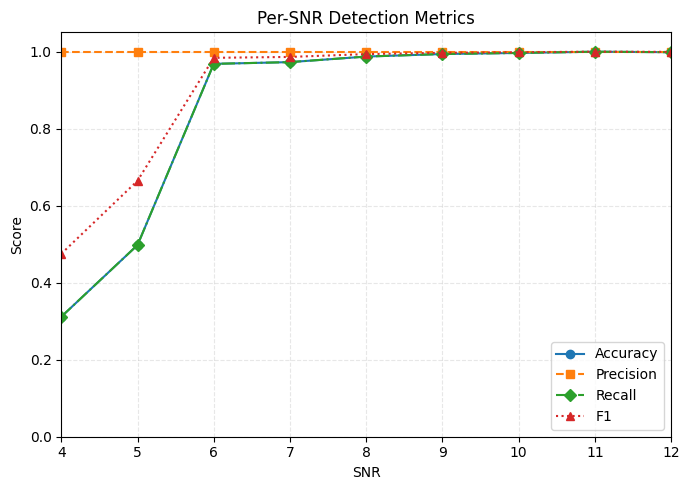

In [19]:
snr_evaluations = [snr_evaluation[0]]
plot_snr_curves(snr_evaluations, SNR_end=12)
plt.show()